In [2]:
import os
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
sns.set()

In [3]:
from pandas_datareader import data
# Only get the adjusted close.
rawData = data.DataReader("SI=F", 
                       start='2000-1-1', 
                       end='2020-4-30', 
                       data_source='yahoo')

rawData.describe()

,High,Low,Open,Close,Volume,Adj Close
count,5048.000000,5048.000000,5048.000000,5048.000000,5.048000e+03,5048.000000
mean,15.133639,14.924146,15.035435,15.029906,1.505991e+05,15.029906
std,8.557144,8.358698,8.464873,8.457472,2.274977e+06,8.457472
min,4.026000,4.026000,4.026000,4.026000,0.000000e+00,4.026000
25%,7.183750,7.136250,7.161500,7.164750,3.000000e+00,7.164750
50%,15.256000,15.087500,15.185000,15.191000,3.100000e+01,15.191000
75%,18.139250,18.005250,18.090250,18.070750,1.340000e+02,18.070750
max,49.520000,47.540001,48.459999,48.584000,6.980156e+07,48.584000


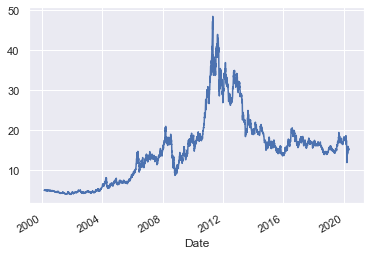

In [4]:
rawData['Open'].plot()

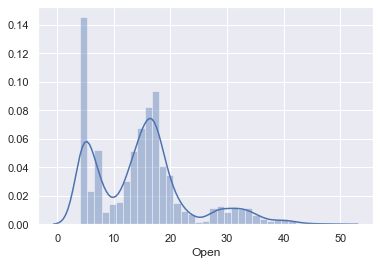

In [5]:
sns.distplot(rawData['Open'])

In [6]:
# TRYING TO REDUCE ON MULTI-COLLINEARITY EARLY BY FINDING RELATIONSHIP OF DATA
rawData['0.5(O+C)'] = ( rawData['Open'] + rawData['Close'] ) * 0.5
rawData['0.5(H+L)'] = ( rawData['High'] + rawData['Low'] ) * 0.5
rawData['0.25(O+C)(H+L)'] = (rawData['0.5(O+C)'] + rawData['0.5(H+L)']) * 0.5
rawData.head()

,High,Low,Open,Close,Volume,Adj Close,0.5(O+C),0.5(H+L),0.25(O+C)(H+L)
Date,,,,,,,,,
2000-02-28,5.095,5.020,5.045,5.048,14203.0,5.048,5.0465,5.0575,5.05200
2000-02-29,5.090,5.035,5.065,5.048,2830.0,5.048,5.0565,5.0625,5.05950
2000-03-01,5.130,5.050,5.070,5.073,511.0,5.073,5.0715,5.0900,5.08075
2000-03-02,5.105,5.000,5.105,5.008,645.0,5.008,5.0565,5.0525,5.05450
2000-03-03,5.110,5.000,5.020,5.099,307.0,5.099,5.0595,5.0550,5.05725


In [7]:
# LETS MAKE AN EXTRACT DATASET OF CURRENT OPEN DATA vs PREVIOUS DAY DATA 
# WE ARE TRYING TO PREDICT CURRENT PRICE BASING ON PREVIOUS DAY DATA
extract  = pd.DataFrame(data = { 'Open' : rawData['Open'][1:len(rawData)].to_numpy(), 'AvOC' : rawData['0.5(O+C)'][ : len(rawData) - 1].to_numpy(), 'AvHL' : rawData['0.5(H+L)'][ : len(rawData) - 1].to_numpy(), 'AvOC-HL' : rawData['0.25(O+C)(H+L)'][ : len(rawData) - 1].to_numpy() })
extract.head()

,Open,AvOC,AvHL,AvOC-HL
0,5.065,5.0465,5.0575,5.05200
1,5.070,5.0565,5.0625,5.05950
2,5.105,5.0715,5.0900,5.08075
3,5.020,5.0565,5.0525,5.05450
4,5.090,5.0595,5.0550,5.05725


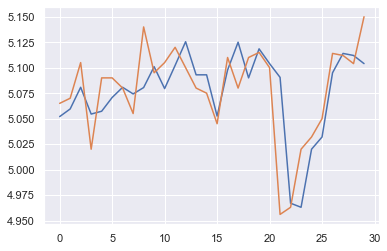

In [8]:
plt.plot(extract['AvOC-HL'][ : 30 ])
plt.plot(extract['Open'][ : 30])

In [9]:
# LETS USE STATS MODELS TO CHECK THE RELATIONSHIP OF THE Y = B1(X) + C USING LEAST-SQUARES
x = extract['AvOC-HL']
y = extract['Open']
x1 = sm.add_constant(x)
result = sm.OLS(y, x1).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Open   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.839e+06
Date:                Sun, 07 Jun 2020   Prob (F-statistic):               0.00
Time:                        17:59:32   Log-Likelihood:                -611.56
No. Observations:                5047   AIC:                             1227.
Df Residuals:                    5045   BIC:                             1240.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.008      0.589      0.556      -0.011       0.020
AvOC-HL        1.0001      0.000   2199.768      0.000       0.999       1.001
==============================================================================
Omnibus:                     1826.160   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49530.849
Skew:                          -1.139   Prob(JB):                         0.00
Kurtosis:                      18.177   Cond. No.                         35.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

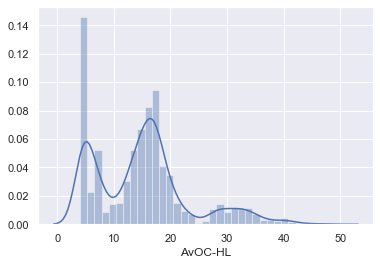

In [10]:
sns.distplot(extract['AvOC-HL'])

In [11]:
# LETS REMOVE THE OUTLIERS
extract = extract[ extract['AvOC-HL']<extract['AvOC-HL'].quantile(0.75) ]
extract.describe()

,Open,AvOC,AvHL,AvOC-HL
count,3785.000000,3785.000000,3785.000000,3785.000000
mean,11.356704,11.350482,11.348553,11.349517
std,5.015756,5.011160,5.009898,5.010467
min,4.026000,4.026000,4.026000,4.026000
25%,5.555000,5.571000,5.585000,5.578000
50%,13.015000,13.010000,13.015000,13.008000
75%,16.129999,16.119000,16.118500,16.122251
max,18.712000,18.153000,18.097501,18.085000


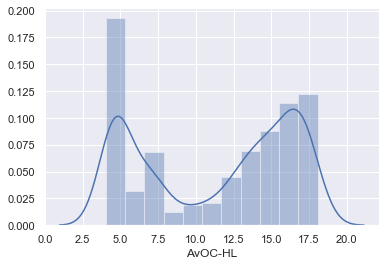

In [12]:
# THE OBSERVED PLOT IS A BETTER NORMALLY DISTRIBUTED PRESENTATION OF THE DATA
sns.distplot(extract['AvOC-HL'])

In [13]:
# SINCE NORMALITY IS IMPROVED WE EXPECT R-SQUARED TO ALSO IMPROVE
x2 = extract['AvOC-HL']
y2 = extract['Open']
xx = sm.add_constant(x2)
results = sm.OLS(y2, xx).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Open   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.697e+06
Date:                Sun, 07 Jun 2020   Prob (F-statistic):               0.00
Time:                        17:59:36   Log-Likelihood:                 961.10
No. Observations:                3785   AIC:                            -1918.
Df Residuals:                    3783   BIC:                            -1906.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.008      0.419      0.675      -0.012       0.018
AvOC-HL        1.0004      0.001   1642.129      0.000       0.999       1.002
==============================================================================
Omnibus:                     1129.143   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26859.056
Skew:                          -0.867   Prob(JB):                         0.00
Kurtosis:                      15.934   Cond. No.                         30.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

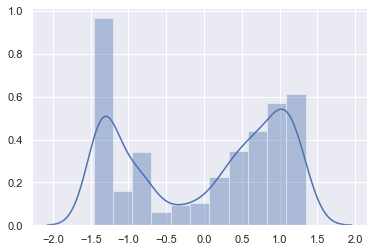

In [14]:
# LETS MAKE THE LINEAR REGRESSION MODEL

# THE TARGETS ARE THE OPENING PRICES
targets = extract['Open']

# THE INPUTS ARE FROM THE FORMULA 0.25(O-C)(H-L) 
inputs = extract['AvOC-HL'].to_numpy().reshape(-1,1)

# LETS SCALE THE INPUTS
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(inputs)
scaled_inputs = scaler.transform(inputs)
sns.distplot(scaled_inputs)

Text(0, 0.5, 'Predictions (y_)')

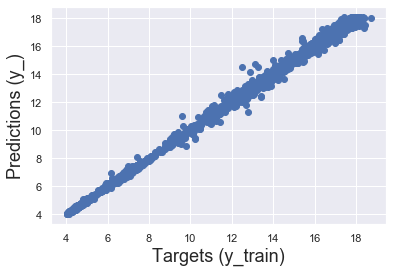

In [15]:
# TRAIN TEST SPLIT
from sklearn.model_selection import train_test_split

# 80% - 20% split
x_train, x_test, y_train, y_test = train_test_split(scaled_inputs, targets, test_size = 0.2, train_size = 0.8, random_state = 365)

# CREATE A REGRESSION
from sklearn.linear_model import LinearRegression

regs = LinearRegression()
regs.fit( x_train, y_train )

# LETS TRAIN THE MODEL
y_ = regs.predict(x_train)

plt.scatter(y_train, y_)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_)',size=18)

Text(0.5, 1.0, 'Residuals')

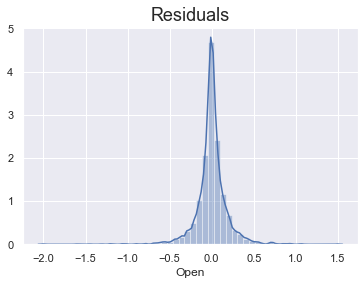

In [16]:
sns.distplot(y_train - y_)
plt.title("Residuals", size=18)

In [17]:
regs.score(x_train,y_train)

0.9985638237135679

In [18]:
# LETS EXTRACT THE BIAS AND WEIGHTS
bias = regs.intercept_
weight = regs.coef_
print(bias, weight)

11.359994006968149 [5.01472835]


Text(0, 0.5, 'Predictions (y_t)')

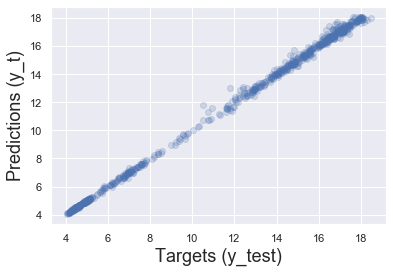

In [19]:
# TESTING THE MODEL
y_t = regs.predict(x_test)

plt.scatter(y_test, y_t, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_t)',size=18)

In [20]:
# LETS INVESTIGATE WHAT THE RESULTS ARE SHOWING
scores = pd.DataFrame(data = { 'Inputs' : x_test.reshape(1,-1)[0], 'Predictions': y_t, 'Targets': y_test })
scores['Residue'] = scores['Targets'] - scores['Predictions']
scores['Loss%'] = scores['Residue'] / scores['Targets'] * 100
scores.describe()

,Inputs,Predictions,Targets,Residue,Loss%
count,757.000000,757.000000,757.000000,757.000000,757.000000
mean,0.013163,11.426002,11.409553,-0.016448,-0.135962
std,1.018210,5.106047,5.093960,0.180734,1.430102
min,-1.455848,4.059310,4.048000,-1.270880,-12.103616
25%,-1.228145,5.201180,5.250000,-0.066211,-0.684327
50%,0.355050,13.140475,13.165000,-0.006015,-0.063613
75%,0.979675,16.272800,16.245001,0.060664,0.569295
max,1.338771,18.073567,18.468000,0.554113,5.307783


In [21]:
scores.head()

,Inputs,Predictions,Targets,Residue,Loss%
18,-1.249453,5.094325,5.110000,0.015675,0.306745
1095,-0.950090,6.595549,6.500000,-0.095549,-1.469989
816,-1.368420,4.497740,4.538000,0.040260,0.887184
3797,1.146648,17.110121,17.065001,-0.045120,-0.264403
892,-1.218763,5.248227,5.260000,0.011774,0.223833


In [22]:
newRaw = data.DataReader("SI=F", 
                       start='2020-3-1', 
                       end='2020-5-15', 
                       data_source='yahoo')
newRaw.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-01,16.605000,16.389999,16.500000,16.555000,164627.0,16.555000
2020-03-02,16.975000,16.389999,16.495001,16.386999,458.0,16.386999
2020-03-03,17.320000,16.740000,16.875000,16.679001,307.0,16.679001
2020-03-04,17.245001,17.049999,17.190001,17.129000,73.0,17.129000
2020-03-05,17.405001,17.120001,17.155001,17.187000,66.0,17.187000


In [23]:
newRaw['AvCO-HL'] = ((( newRaw['Open'] + newRaw['Close'] ) * 0.5) + (( newRaw['High'] + newRaw['Low'] ) * 0.5)) * 0.5
new_inputs = newRaw['AvCO-HL'][ 0 : len( newRaw ) - 1 ].to_numpy().reshape(-1,1)
new_targets = newRaw['Open'][ 1 : len( newRaw ) ].to_numpy()

scaler.fit(new_inputs)
new_scaled_inputs = scaler.transform(new_inputs)
new_y_t = regs.predict(new_scaled_inputs)
residue = new_targets - new_y_t

new_results = pd.DataFrame( data = {"Inputs" : new_scaled_inputs.reshape(1,-1)[0], "Predictions" : new_y_t , "Targets": new_targets, "Residue" : residue} )
new_results.describe()

,Inputs,Predictions,Targets,Residue
count,6.300000e+01,63.000000,63.000000,63.000000
mean,-6.273641e-16,11.359994,15.219524,3.859530
std,1.008032e+00,5.055008,1.233308,3.869582
min,-2.711258e+00,-2.236227,11.975000,-3.452459
25%,-4.894237e-01,8.905667,14.730000,2.096868
50%,8.287165e-02,11.775573,15.310000,3.634427
75%,4.476255e-01,13.604714,15.747500,5.548973
max,1.899896e+00,20.887459,17.490000,14.361227


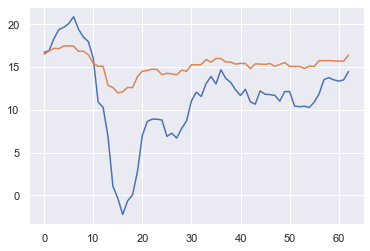

In [24]:
plt.plot(new_y_t)
plt.plot(new_targets) 